# Imports

In [59]:
%reload_ext autoreload
%autoreload 2

import os
import torch
import datetime
import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

from rnn import LSTM
from utils import custom_collate
from decomposition import decompose
from forecast import create_rnn_forecast

In [30]:
df = pd.read_csv('daily_prices/WRB.csv')
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume,DayOfWeek
1252,2023-11-15,68.470001,69.320000,68.169998,68.540001,68.540001,1691500,2
1253,2023-11-16,69.019997,69.790001,68.860001,69.769997,69.769997,1119500,3
1254,2023-11-17,69.860001,70.470001,69.629997,70.209999,70.209999,1107600,4
1255,2023-11-20,69.910004,70.269997,69.599998,69.650002,69.650002,817100,0
1256,2023-11-21,69.949997,71.330002,69.949997,71.139999,71.139999,1216900,1


# Test dataset

In [48]:
from dataset import Stock_Data
from torch.utils.data import DataLoader

dataset = Stock_Data('daily_prices/AAPL.csv', 252, 10, 4)

In [111]:
# load stock data
dataset = Stock_Data('daily_prices/AAPL.csv', 252, 10, 4)
train, val = train_test_split(dataset, test_size=0.1, random_state=42)

# create dataloaders
trainloader = DataLoader(dataset=train, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate)
#trainloader = DataLoader(dataset=train, batch_size=4, shuffle=True, num_workers=0)
valloader = DataLoader(dataset=val, batch_size=4, shuffle=True, num_workers=0, collate_fn=custom_collate)

In [112]:
dataset.__getitem__(0)

(tensor([[0.6039, 0.6072, 0.6351, 0.6081, 0.2396],
         [0.6064, 0.6102, 0.6422, 0.6377, 0.5101],
         [0.6002, 0.6101, 0.6407, 0.6317, 0.4986],
         [0.6179, 0.5967, 0.6460, 0.6113, 0.3782],
         [0.5852, 0.5807, 0.6170, 0.6004, 0.3680],
         [0.6107, 0.5987, 0.6388, 0.6040, 0.3722],
         [0.5974, 0.5976, 0.6380, 0.6280, 0.4521],
         [0.5900, 0.5935, 0.6228, 0.6059, 0.4670],
         [0.5648, 0.5669, 0.5955, 0.5825, 0.4422],
         [0.5539, 0.5535, 0.5794, 0.5514, 0.4262]], dtype=torch.float64),
 tensor([[0.5457, 0.5547, 0.5757, 0.5617, 0.5102],
         [0.5643, 0.5656, 0.5893, 0.5766, 0.5062],
         [0.5627, 0.5688, 0.5955, 0.5840, 0.3862],
         [0.5669, 0.5348, 0.5891, 0.5394, 0.1075],
         [0.5175, 0.5149, 0.5424, 0.5230, 0.3750],
         [0.5219, 0.5132, 0.5422, 0.5144, 0.5020],
         [0.5044, 0.5098, 0.5424, 0.5254, 0.3588],
         [0.5175, 0.5225, 0.5517, 0.5440, 0.3957],
         [0.5342, 0.5369, 0.5605, 0.5447, 0.4759],
        

In [113]:
#next(iter(trainloader))
for j, data in enumerate(trainloader):
    print(data[0].shape)
    break

torch.Size([4, 10, 5])


In [88]:
import torch

# Create a tensor
tensor_example = torch.tensor([[1, 2, 3, 4, 5], [1, 2, 3, 4, 5]])

# Access elements using negative indexing
last_element = tensor_example[-1:, :]  # Equivalent to tensor_example[4]

# Print the results
print(last_element)

tensor([[1, 2, 3, 4, 5]])


# Stats Models Seasonal Decompose

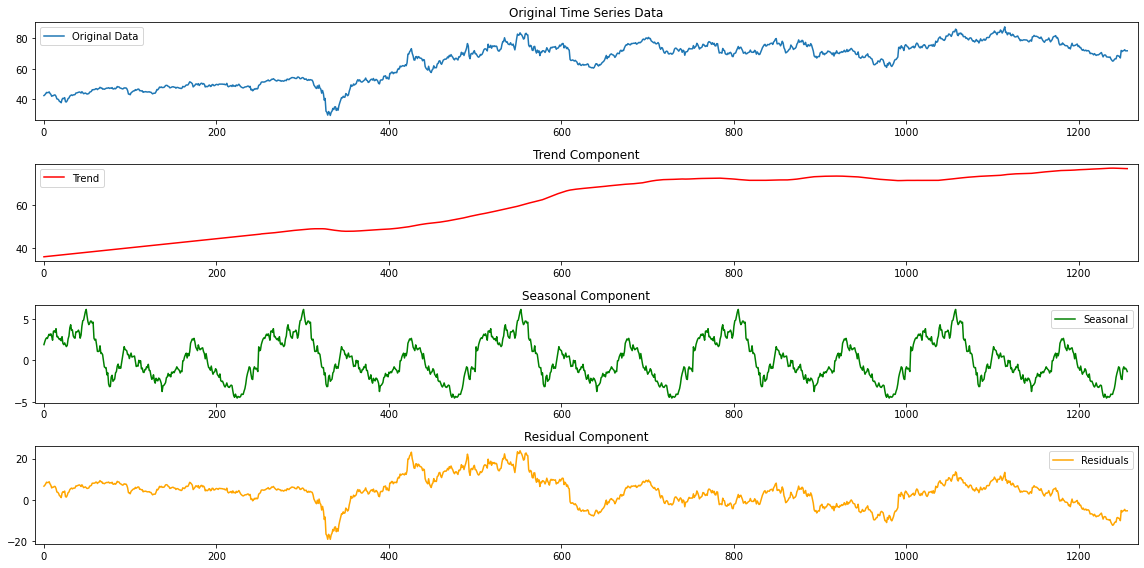

In [6]:
df = pd.read_csv('daily_prices/HOLX.csv')

# Extract the time and value columns
time_series = np.array(range(len(df['Date'])))  # Replace with your time column name
values = df['Close']                            # Replace with your value column name

# Perform seasonal decomposition
result = sm.tsa.seasonal_decompose(values, model='additive', period=252, extrapolate_trend=25, two_sided=False)

# Plot the original data, trend, seasonal, and residuals
plt.figure(figsize=(16, 8))
plt.subplot(4, 1, 1)
plt.plot(time_series, values, label='Original Data')
plt.xlim(-10,1268)
plt.legend()
plt.title('Original Time Series Data')

plt.subplot(4, 1, 2)
plt.plot(time_series, result.trend, label='Trend', color='red')
plt.xlim(-10,1268)
plt.legend()
plt.title('Trend Component')

plt.subplot(4, 1, 3)
plt.plot(time_series, result.seasonal, label='Seasonal', color='green')
plt.xlim(-10,1268)
plt.legend()
plt.title('Seasonal Component')

plt.subplot(4, 1, 4)
plt.plot(time_series, result.resid + result.seasonal, label='Residuals', color='orange')
plt.xlim(-10,1268)
plt.legend()
plt.title('Residual Component')
plt.tight_layout()
plt.show()

# Test residual forecast

In [15]:
device = 'cpu'
horizon = 20
file = 'daily_prices/WRB.csv'

data = pd.read_csv(file).drop(columns=['Adj Close'])

# Load model
kwargs, state = torch.load('models/rnn/weights/best.pth', map_location=torch.device(device))
model = LSTM(**kwargs)
model.load_state_dict(state)
model.to(device)
model.eval()

# decompose data
decomposition = decompose(data)

# create residual forecast from model
rnn_forecast = create_rnn_forecast(torch.tensor(decomposition['input'].values).float(), model, horizon, device)
rnn_forecast.index = [decomposition['input'].index[-1]+1 + i for i in range(len(rnn_forecast.index))]

# Plot the original data, trend, seasonal, and residuals
plt.figure(figsize=(16, 8))
plt.plot(decomposition['input']['Close'][-252:], linewidth=0.5)
plt.plot(rnn_forecast['Close'], linewidth=0.5)
plt.title('Original Time Series Data')
plt.show()

RuntimeError: input must have 3 dimensions, got 2

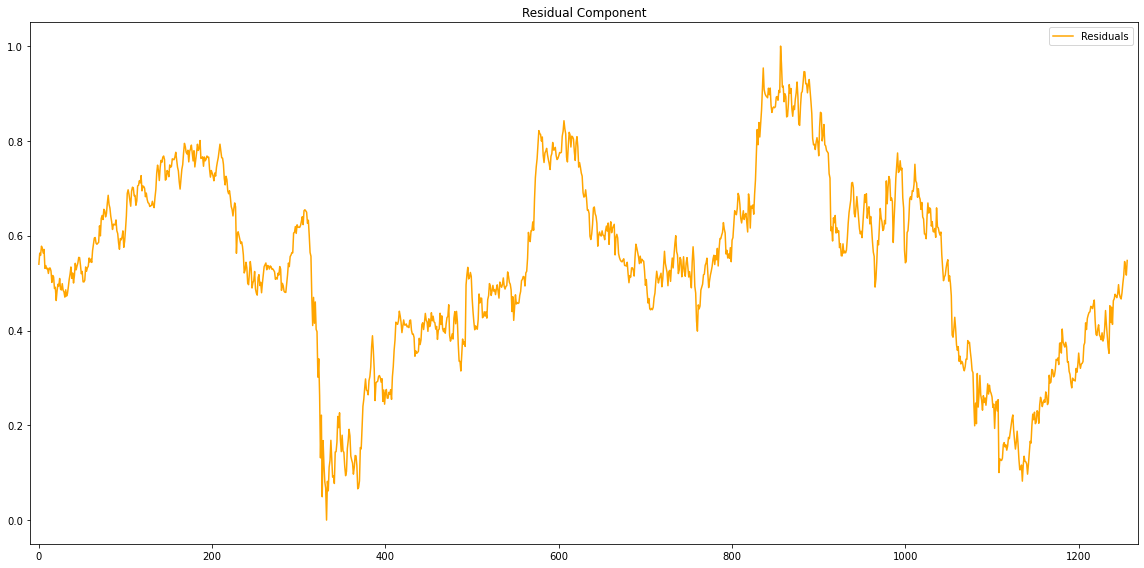

In [27]:
file = 'daily_prices/WRB.csv'

data = pd.read_csv(file).drop(columns=['Adj Close'])

# decompose data
decomposition = decompose(data)

plt.figure(figsize=(16, 8))
plt.plot(decomposition['input']['Close'], label='Residuals', color='orange')
plt.xlim(-10,1268)
plt.legend()
plt.title('Residual Component')
plt.tight_layout()
plt.show()

In [36]:
import os
import pandas as pd

data_path = 'training_data'

# load all data locations
all_files = os.listdir(data_path)
if '_.txt' in all_files: all_files.remove('_.txt')
files = []

# set max file length ( 5 years worth of data )
max = 1257
for file in all_files:
    df = pd.read_csv(os.path.join(data_path, file), index_col=0)
    if len(df.index) == max:
        files.append(file)
    elif len(df.index) > max:
        df.iloc[:1257].to_csv(os.path.join(data_path, file))
        files.append(file)
    elif len(df.index) < max:
        pass
data = files

In [40]:
x, y = [1,2]
y

2